# Clustering and Dimensionality Reduction : Course Project

# Exploring Dimensionality Reduction Techniques on MNIST Handwritten Digit Dataset

# Rhichard Koh

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# Importing Data

In [ ]:
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize around the mean 0.5
])

# Download and load the training data
trainset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST(root='./data', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 219483760.03it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 49503757.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78595926.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16638016.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#PCA

In [ ]:
# Flatten the images for PCA
X_train_flattened = trainset.data.view(len(trainset), -1).numpy()
X_test_flattened = testset.data.view(len(testset), -1).numpy()

# Normalize data
X_train_flattened = X_train_flattened / 255.0
X_test_flattened = X_test_flattened / 255.0

# PCA with different number of components
components = [50, 100, 150, 200]
for n_components in components:
    pca = PCA(n_components=n_components)
    pca.fit(X_train_flattened)
    X_train_pca = pca.transform(X_train_flattened)
    X_test_pca = pca.transform(X_test_flattened)
    X_reconstructed_pca = pca.inverse_transform(X_train_pca)
    reconstruction_loss = mean_squared_error(X_train_flattened, X_reconstructed_pca)

    # Logistic regression classifier to classify our reconstructed images
    lr = LogisticRegression(max_iter=1000, solver='sag', multi_class='multinomial')
    lr.fit(X_train_pca, trainset.targets.numpy())

    # Evaluating on a subset of the test set
    validation_index = np.random.choice(len(testset), 1000, replace=False)
    validation_images_pca = X_test_pca[validation_index]
    validation_labels = testset.targets.numpy()[validation_index]

    validation_predictions = lr.predict(validation_images_pca)
    accuracy = accuracy_score(validation_labels, validation_predictions)
    print(f'Reconstruction loss for PCA with {n_components} components: {reconstruction_loss} Classification Accuracy: {accuracy}')

Reconstruction loss for PCA with 50 components: 0.011795084610364161 Classification Accuracy: 0.924
Reconstruction loss for PCA with 100 components: 0.005756633405031867 Classification Accuracy: 0.93
Reconstruction loss for PCA with 150 components: 0.0034891502018314425 Classification Accuracy: 0.924
Reconstruction loss for PCA with 200 components: 0.0022767954728689765 Classification Accuracy: 0.926


The best scoring minimal components is 100 as it has the highest accuracy and a decent reconstruction loss.

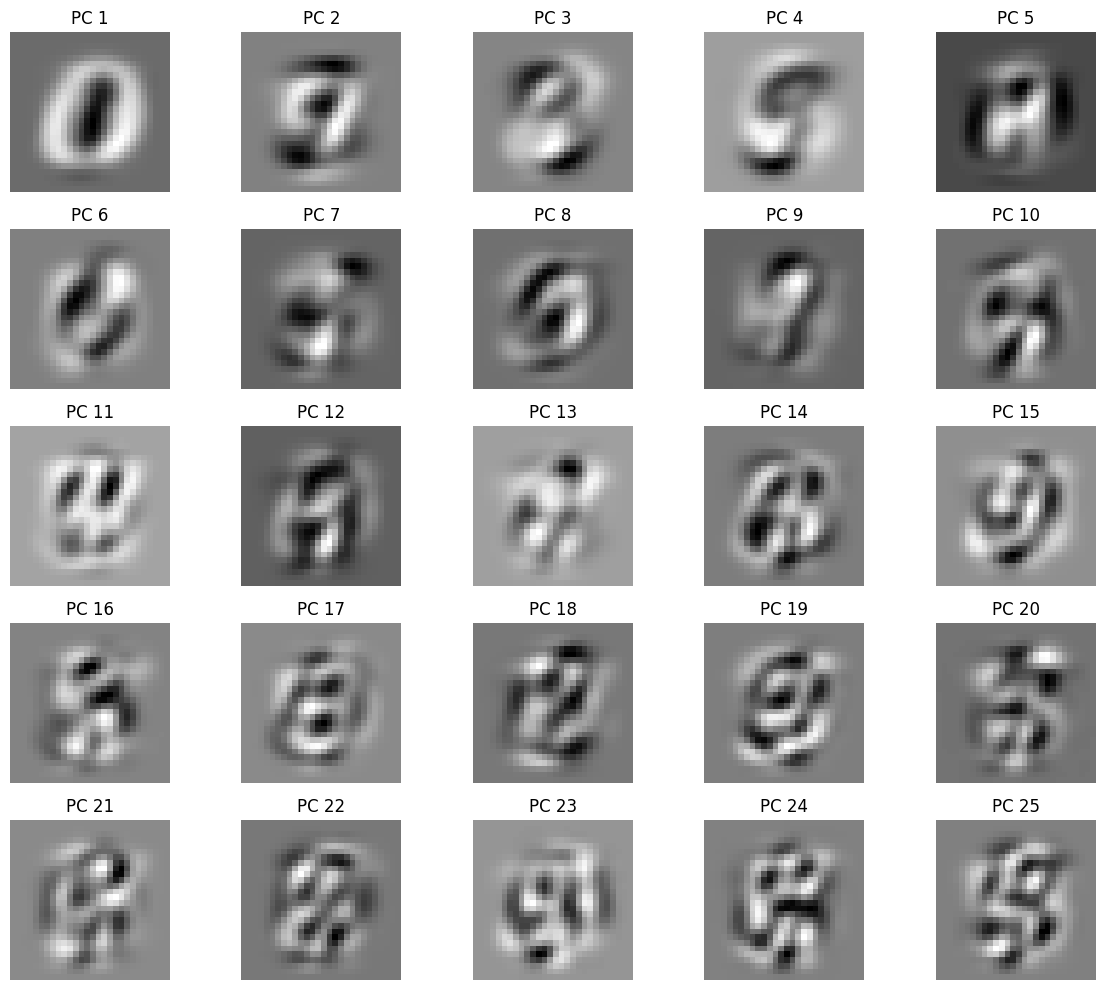

In [ ]:
# Visualizing the first 25 PCA'S
fig, axes = plt.subplots(5, 5, figsize=(12, 10))

for i in range(25):
    row = i // 5
    col = i % 5
    pc_image = pca.components_[i].reshape(28, 28)  # Reshape the principal component to 28x28
    axes[row, col].imshow(pc_image, cmap='gray')
    axes[row, col].set_title(f'PC {i+1}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

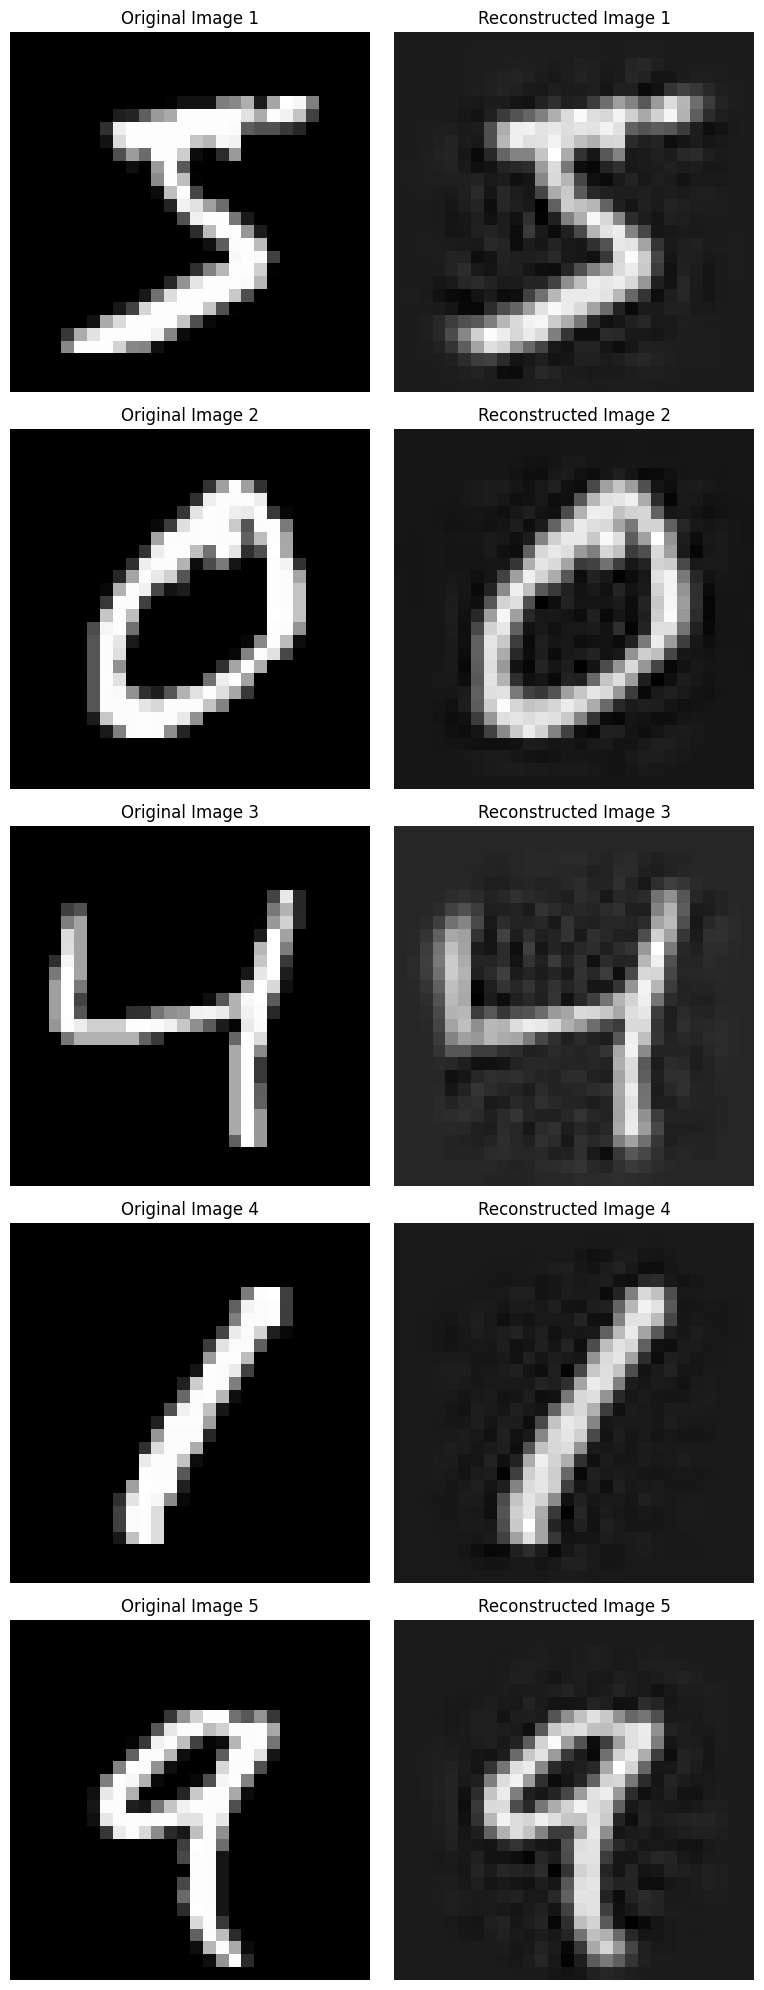

In [ ]:
# Comparing the reconstructed images to the original images
fig, axes = plt.subplots(5, 2, figsize=(8, 4 * 5))

for i in range(5):
    # Original image
    original_image = X_train_flattened[i].reshape(28, 28)

    # Reconstructed image after PCA
    reconstructed_image = pca.inverse_transform(X_train_pca[i]).reshape(28, 28)

    # Plot original image
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Plot reconstructed image
    axes[i, 1].imshow(reconstructed_image, cmap='gray')
    axes[i, 1].set_title(f'Reconstructed Image {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

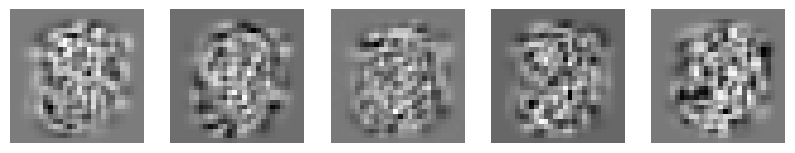

In [ ]:
def generate_digits(n_digits):
    fig, axes = plt.subplots(1, n_digits, figsize=(10, 2))
    for i in range(n_digits):
        # Randomly sample from the distribution of the PCA coefficients
        random_sample = np.random.normal(0, 1, pca.n_components)

        # Generate new data by inverse transforming the random sample
        new_digit = pca.inverse_transform(random_sample)

        # Rescale to original range and reshape to 28x28
        new_digit_image = new_digit.reshape(28, 28)

        # Plot
        ax = axes[i]
        ax.imshow(new_digit_image, cmap='gray')
        ax.axis('off')
    plt.show()

# Generate and display 5 new digits
generate_digits(5)

The images were generated by selecting random points within a space transformed by Principal Component Analysis (PCA) and then converting these points back into the format of the original images. As a result, these images might not look exactly like any specific digits from the MNIST dataset. Instead, they display variations based on the major trends or features identified by the PCA.

#Autoencoder

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        encoded = torch.relu(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return decoded

# Train autoencoder
def train_autoencoder(hidden_size, results={}):

    model = Autoencoder(784, hidden_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    num_epochs = 8
    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, torch.flatten(images, start_dim=1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(trainloader)

    results[hidden_size] = {'reconstruction_loss': average_loss}

    encoded_train = []
    train_labels = []
    for data, target in trainloader:
        encoded = model(data)
        encoded_train.append(encoded.detach().cpu().numpy())
        train_labels.append(target.numpy())
    encoded_train = np.concatenate(encoded_train, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    clf = LogisticRegression(max_iter=1000, solver='sag', multi_class='multinomial')
    clf.fit(encoded_train, train_labels)

    encoded_val = []
    val_labels = []
    for data, target in testloader:
        encoded = model(data)
        encoded_val.append(encoded.detach().cpu().numpy())
        val_labels.append(target.numpy())
    encoded_val = np.concatenate(encoded_val, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    val_predictions = clf.predict(encoded_val)
    accuracy = accuracy_score(val_labels, val_predictions)

    results[hidden_size]['classification_accuracy'] = accuracy
    print(f'Encoding Dim: {hidden_size}, Classification Accuracy: {accuracy}')

    return model, loss.item(), results

hidden_sizes = [50, 100, 150, 200]
results = {}
for hidden_size in hidden_sizes:
    model, loss, results = train_autoencoder(hidden_size,results)
    print(f'Reconstruction loss for Autoencoder with {hidden_size} hidden units:', loss)
for encoding_dim, metrics in results.items():
    print(f'{encoding_dim}: Reconstruction Loss: {metrics["reconstruction_loss"]}, Classification Accuracy: {metrics["classification_accuracy"]}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Encoding Dim: 50, Classification Accuracy: 0.8038
Reconstruction loss for Autoencoder with 50 hidden units: 0.9075490236282349


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Encoding Dim: 100, Classification Accuracy: 0.8621
Reconstruction loss for Autoencoder with 100 hidden units: 0.8906221985816956


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Encoding Dim: 150, Classification Accuracy: 0.8531
Reconstruction loss for Autoencoder with 150 hidden units: 0.8868787884712219


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Encoding Dim: 200, Classification Accuracy: 0.8583
Reconstruction loss for Autoencoder with 200 hidden units: 0.883091390132904
50: Reconstruction Loss: 0.9358660034152236, Classification Accuracy: 0.8038
100: Reconstruction Loss: 0.9164198400623509, Classification Accuracy: 0.8621
150: Reconstruction Loss: 0.9233703469035468, Classification Accuracy: 0.8531
200: Reconstruction Loss: 0.9157706576623896, Classification Accuracy: 0.8583


The best minimum hidden encoding dimmension was 100 because it had the highest classification accuracy while still having the 2nd lowest reconstruction loss.

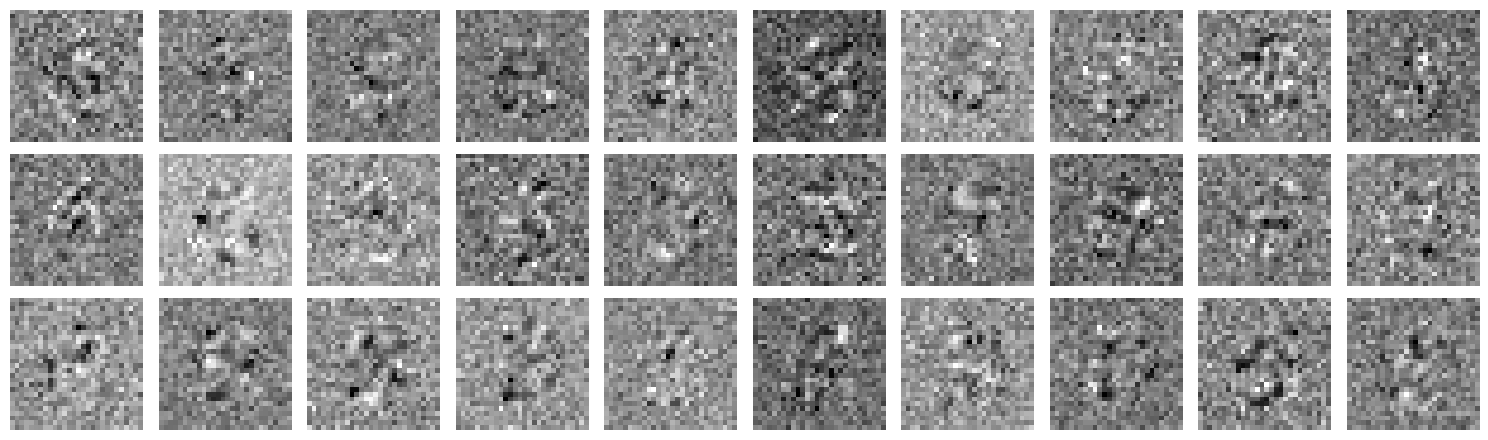

In [ ]:
hidden_size = 100
autoencoder = Autoencoder(784, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

for epoch in range(8):
    for data, _ in trainloader:
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, torch.flatten(data, start_dim=1))
        loss.backward()
        optimizer.step()


# Generate new handwritten digits using the trained autoencoder
np.random.seed(42)
random_noise = np.random.normal(0,1,(30, hidden_size))
random_noise = torch.tensor(random_noise, dtype=torch.float32)
generated_images = autoencoder.decoder(random_noise).detach().cpu().numpy()

# Plot the generated images
fig, axes = plt.subplots(3, 10, figsize=(15, 4.5))  # Adjusted for 3 rows and 10 columns
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

#RBN

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

In [ ]:
# Define the RBM class
class RBM(torch.nn.Module):
    def __init__(self, input, hiddensize):
        super(RBM, self).__init__()
        self.W = torch.nn.Parameter(torch.randn(hiddensize, input) * 0.01)
        self.v_bias = torch.nn.Parameter(torch.zeros(input))
        self.h_bias = torch.nn.Parameter(torch.zeros(hiddensize))

    def sample_h(self, v):
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        h_sample = torch.bernoulli(h_prob)
        return h_sample

    def sample_v(self, h):
        v_prob = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        v_sample = torch.bernoulli(v_prob)
        return v_sample

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.v_bias)
        wx_b = torch.matmul(v, self.W.t()) + self.h_bias
        hidden_term = torch.sum(torch.log(1 + torch.exp(wx_b)), dim=1)
        return -vbias_term - hidden_term

    def forward(self, v):
        h = self.sample_h(v)
        v_recon = self.sample_v(h)
        return v_recon

# List of encoding dimensions to test
hidden_size = [50, 100, 150, 200]
results_dict = {}

for size in hidden_size:
    rbm = RBM(input=784, hiddensize=size)
    optimizer = torch.optim.SGD(rbm.parameters(), lr=0.01)

    # Training loop for RBM
    for epoch in range(8):  # Adjust the number of epochs if necessary
        loss_sum = 0
        for data, _ in trainloader:
            data = data.view(-1, 784)  # Flatten the images
            data = torch.clamp(data, 0.0, 1.0)
            data = (data > 0.5).float()  # Convert to binary using thresholding
            v_recon = rbm(data)
            loss = torch.mean(rbm.free_energy(data)) - torch.mean(rbm.free_energy(v_recon.detach()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
        average_loss = loss_sum / len(trainloader)
    results_dict[size] = {'reconstruction_loss': average_loss}

    # Extract features from the training set
    encoded_train = []
    train_labels = []
    for data, target in trainloader:
        data = data.view(-1, 784)
        data = torch.clamp(data, 0.0, 1.0)
        data = (data > 0.5).float()  # Convert to binary using thresholding
        encoded = rbm.sample_h(data)  # Get encoded (hidden) representations
        encoded_train.append(encoded.detach().numpy())
        train_labels.append(target.numpy())
    encoded_train = np.concatenate(encoded_train, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # Train a softmax classifier
    lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    lr.fit(encoded_train, train_labels)

    # Evaluate classification accuracy on the test set
    encoded_test = []
    test_labels = []
    for data, target in testloader:
        data = data.view(-1, 784)
        data = torch.clamp(data, 0.0, 1.0)
        data = (data > 0.5).float()  # Convert to binary using thresholding
        encoded = rbm.sample_h(data)
        encoded_test.append(encoded.detach().numpy())
        test_labels.append(target.numpy())
    encoded_test = np.concatenate(encoded_test, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    test_predictions = lr.predict(encoded_test)
    accuracy = accuracy_score(test_labels, test_predictions)

    # Record the classification accuracy
    results_dict[size]['classification_accuracy'] = accuracy
    print(f'Hidden Size: {size}, Reconstruction Loss: {average_loss}, Classification Accuracy: {accuracy}')

# Print the results for all encoding dimensions
print("Results for different Hidden Size:")
for size, metrics in results_dict.items():
    print(f'{size}: Reconstruction Loss: {metrics["reconstruction_loss"]}, Classification Accuracy: {metrics["classification_accuracy"]}')

Encoding Dim: 50, Reconstruction Loss: -19.923210117608498, Classification Accuracy: 0.8439
Encoding Dim: 75, Reconstruction Loss: -18.55157110787658, Classification Accuracy: 0.8666
Encoding Dim: 100, Reconstruction Loss: -17.291857076860442, Classification Accuracy: 0.8758
Encoding Dim: 150, Reconstruction Loss: -15.531131760652132, Classification Accuracy: 0.8845
Encoding Dim: 200, Reconstruction Loss: -14.382853977715792, Classification Accuracy: 0.8889
Results for different Encoding Dimensions:
50: Reconstruction Loss: -19.923210117608498, Classification Accuracy: 0.8439
75: Reconstruction Loss: -18.55157110787658, Classification Accuracy: 0.8666
100: Reconstruction Loss: -17.291857076860442, Classification Accuracy: 0.8758
150: Reconstruction Loss: -15.531131760652132, Classification Accuracy: 0.8845
200: Reconstruction Loss: -14.382853977715792, Classification Accuracy: 0.8889


The best minimum hidden encoding dimmension was 150 because it had the 2nd highest classification and the 2nd lowest reconstruction loss but it is about the same as our max value which is 200. When trying to go for efficiency and the smallest size we can go, 150 is better than 200.

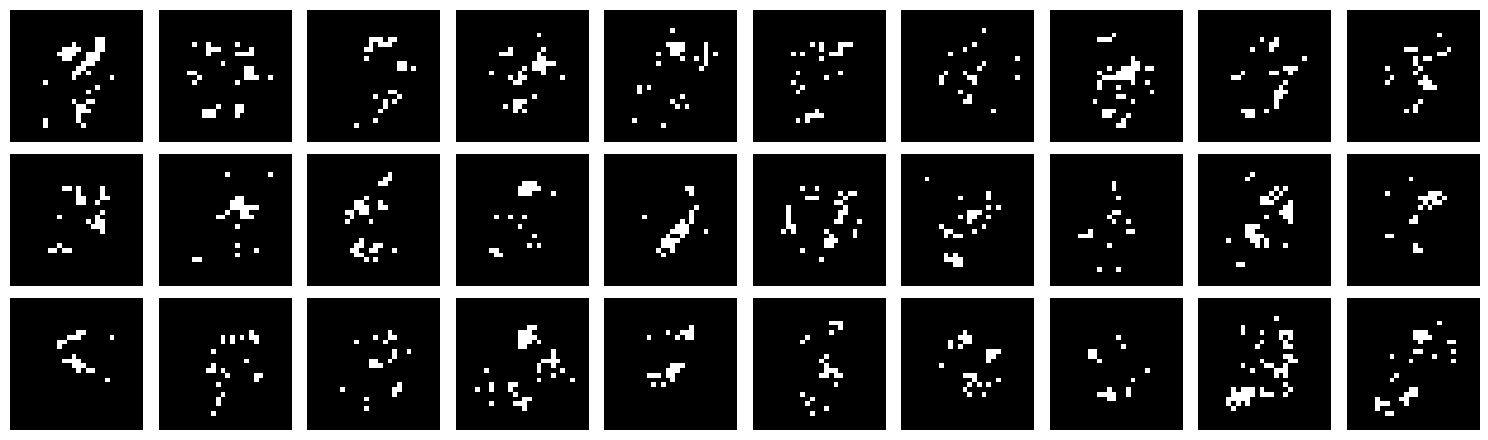

In [ ]:
# Set the number of hidden dimensions
hiddensize = 150

# Train an RBM with 150 hidden dimensions (assuming train_loader is defined)
rbm = RBM(n_vis=784, n_hid=hiddensize)
optimizer = torch.optim.SGD(rbm.parameters(), lr=0.1)

for epoch in range(8):  # Adjust the number of epochs if necessary
    for data, _ in trainloader:
        data = data.view(-1, 784)
        data = torch.clamp(data, 0.0, 1.0)
        data = (data > 0.5).float()  # Convert to binary using thresholding
        v_recon = rbm(data)
        loss = torch.mean(rbm.free_energy(data)) - torch.mean(rbm.free_energy(v_recon.detach()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Generate 30 new images using the trained RBM
np.random.seed(42)  # Set a seed for reproducibility
random_hidden = torch.bernoulli(torch.rand(30, hiddensize))  # Randomly sample the hidden units
generated_images = rbm.sample_v(random_hidden).detach().numpy()  # Reconstruct the visible units

# Plot the generated images
fig, axes = plt.subplots(3, 10, figsize=(15, 4.5))  # Adjusted for 3 rows and 10 columns
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

#DBN

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from kerastuner.tuners import RandomSearch

def load_data():
    # Load and preprocess the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 784).astype('float32') / 255
    x_test = x_test.reshape(-1, 784).astype('float32') / 255
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

def build_model(hp):
    model = Sequential()
    # Hyperparameters to tune
    units = hp.Choice('units', values=[50, 100, 150, 200])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)

    # Model architecture
    model.add(Dense(units=units, activation='relu', input_shape=(784,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

x_train, y_train, x_test, y_test = load_data()
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials to cover the grid
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='DBN_grid_search')

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Reloading Tuner from tuner_dir/DBN_grid_search/tuner0.json
Best number of units: 200
Best dropout rate: 0.30000000000000004
Epoch 1/50
1875/1875 [==============================] - 18s 9ms/step - loss: 0.2960 - accuracy: 0.9098 - val_loss: 0.1286 - val_accuracy: 0.9607
Epoch 2/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1493 - accuracy: 0.9553 - val_loss: 0.0959 - val_accuracy: 0.9679
Epoch 3/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1188 - accuracy: 0.9638 - val_loss: 0.0737 - val_accuracy: 0.9767
Epoch 4/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1014 - accuracy: 0.9685 - val_loss: 0.0719 - val_accuracy: 0.9768
Epoch 5/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0892 - accuracy: 0.9724 - val_loss: 0.0780 - val_accuracy: 0.9769
Epoch 6/50
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0801 - accuracy: 0.9753 - val_loss: 0.0732 - val_accuracy: 0.9785
Epoch 

In [17]:
# Get all completed trials, sorted by their performance
sorted_trials = sorted(tuner.oracle.get_best_trials(num_trials=10), key=lambda x: x.score)

# Loop through the top 10 trials to display hyperparameters and corresponding metrics
for i, trial in enumerate(sorted_trials):
    print(f"Top {i+1} Trial:")
    print("Hyperparameters:", trial.hyperparameters.values)
    print("Objective (e.g., Loss):", trial.score)  # Score refers to the objective you are optimizing, often the validation loss

    # Accessing specific metrics like 'loss' and 'accuracy'
    # Make sure these names match how they were recorded during the search
    try:
        val_loss = trial.metrics.get_best_value('val_loss')
        val_accuracy = trial.metrics.get_best_value('val_accuracy')
        print(f"Best Validation Loss: {val_loss}")
        print(f"Best Validation Accuracy: {val_accuracy}")
    except KeyError as e:
        print(f"Error retrieving metric: {e}")

    print("\n")


Top 1 Trial:
Hyperparameters: {'units': 50, 'dropout_rate': 0.4}
Objective (e.g., Loss): 0.9639000296592712
Best Validation Loss: 0.12775953114032745
Best Validation Accuracy: 0.9639000296592712


Top 2 Trial:
Hyperparameters: {'units': 50, 'dropout_rate': 0.30000000000000004}
Objective (e.g., Loss): 0.9678999781608582
Best Validation Loss: 0.10606943070888519
Best Validation Accuracy: 0.9678999781608582


Top 3 Trial:
Hyperparameters: {'units': 50, 'dropout_rate': 0.2}
Objective (e.g., Loss): 0.97079998254776
Best Validation Loss: 0.09899251908063889
Best Validation Accuracy: 0.97079998254776


Top 4 Trial:
Hyperparameters: {'units': 100, 'dropout_rate': 0.4}
Objective (e.g., Loss): 0.9760000109672546
Best Validation Loss: 0.08561421930789948
Best Validation Accuracy: 0.9760000109672546


Top 5 Trial:
Hyperparameters: {'units': 100, 'dropout_rate': 0.30000000000000004}
Objective (e.g., Loss): 0.9763000011444092
Best Validation Loss: 0.08270733803510666
Best Validation Accuracy: 0.9763

After completing the grid search the best value for our hidden size is 200 has it gave us the lowest loss and highest accuracy.